Ce notebook python peut être exécuté sur le serveur JupyterHub de l'UGA en cliquant sur ce badge
[![badge](https://img.shields.io/badge/launch-UGA%20JupyterHub-F5A252.svg?logo=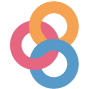)](https://gricad-jupyter.univ-grenoble-alpes.fr/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Ffchatelain%2FExemplesFLO&urlpath=lab%2Ftree%2FExemplesFLO%2FBE1%2FBE1_Wiener_template.ipynb&branch=master)
(connexion avec vos identifiants Agalan)

In [1]:
# afficher des figures dans le notebook
# utiliser 'widget' au lieu de 'inline' pour un affichage interactif
%matplotlib inline

# BE 1 - Filtrage Linéaire Optimal 


**Objectif :** Restaurer le signal de l'activité électrique d'un muscle ou d'un nerf à l'aide du filtrage de Wiener discret.

Ce notebook python suit la trame de l'énoncé du [BE sur Wiener](https://chamilo.grenoble-inp.fr/courses/ENSE3A24EMAABJ0/document/BE_1/BE_wiener.pdf?cidReq=ENSE3A24EMAABJ0&id_session=0&gidReq=0&gradebook=0&origin=) (à bien lire pour comprendre le problème et le travail demandé), et est volontairement déjà très complet. Le but est que vous vous concentriez sur l'essentiel : 
- le principe du filtre de Wiener auto-ajusté
- le dimensionnement des paramètres de ce filtre
- la résolution du système de Wiener-Hopf
- l'interprétation des résultats

Des commentaires et des questions vous sont régulièrement adressés afin de vous guider, et les parties que vous devrez modifier dans le code sont toujours suivies de la mention `FIXME` en commentaire.

Les principaux modules ou fonctions Python utiles à ce BE sont *importées* dans le bloc de code qui suit.
On y définit également la fonction `xcorr()` avec une syntaxe similaire à celle de Matlab.
On rappelle que la documentation pour chaque module, objet ou fonction s’obtient à l’aide de la fonction `help()`, e.g. :
> `help(xcorr)`

permet d’obtenir les informations relatives au calcul de l'intercorrélation entre deux signaux.

*Le bloc de code qui suit est un préambule contenant l'ensemble des fonctions utiles à ce BE*.

In [2]:
# Dépendances vers les fonctions utiles pour construire/appliquer le filtre de Wiener
import scipy.io # Lire les données en .mat
import numpy as np # Représentation machine par np array
from scipy.signal import welch # Périodogramme, densité spectral
from scipy.signal import lfilter # Fonction de filtrage
from scipy.signal.windows import hann # Hanning window
from scipy.linalg import toeplitz # Matrice Toeplitz
from scipy.linalg import solve  # Résoud les système Ax = b

# Dépendance pour les graphiques
import matplotlib.pyplot as plt

# Equivalent de fonctions Matlab en Python
def xcorr(y1, y2, maxlag = -1, scale = 'biased'):
    """ "returns the cross-correlation of two discrete-time sequences.
         Cross-correlation measures the similarity
         between a vector x and shifted (lagged)
         copies of a vector y as a function of the lag.""

        Définition de 'xcorr' Matlab, cf.
        https://www.mathworks.com/help/matlab/ref/xcorr.html

    Entrées:
        y1, y2 : ndarray de même longueur.
                 les signaux
        maxlag : integer 
                la corrélation est calculée pour tous les retards 
                r dans -maxlag,...,maxlag.
                Par défaut, maxlag=-1 correspond au nombre total de points 
                dans le signal.
        scale : {'biased', 'unbiased'}, optional
            'biased':
              Par défaut. Pour chaque retard, la constante de 
              normalisation est la même : le nombre N d'échantillons
              dans le signal. Cela biaise vers 0 la corrélation estimée
              pour des grands retards.
            'unbiased':
              La constante de normalisation vaut N-|r| et  correspond 
              au nombre de produits croisés qui sont effectivement sommés pour
              chaque retard r.
    Sorties:
        xcorr: ndarray
               corrélations pour chaque retard dans -maxlag,...,maxlag
        lag:   ndarray 
               retards associés : -maxlag,...,maxlag
    """
    l_ = len(y1)
    if l_ != len(y2):
        raise ValueError('Les longueurs doivent être identiques.')
    
    # Biased or unbiased scaling?
    scale_from_option_dict = {'b': 0,'u': 1}
    scale = scale_from_option_dict[scale.lower()[0]]

    # Do correlation
    corr = np.correlate(y1, y2, mode='full') # / np.sqrt(P_y1 * P_y2)
    
    if scale == 0:
        # The biased scaling factor is N (signal length)
        corr = corr / l_
    elif scale == 1:
        # The unbiased scaling factor is N - |r| where r is the lag
        # (i.e. the number of cross-terms to estime the correlation at lag r)
        unbiased_sample_size = np.correlate(np.ones(l_), np.ones(l_),
                                            mode='full')
        corr = corr / unbiased_sample_size
    
    shift = l_
    lags = np.arange(2*l_-1) - shift + 1
    
    if maxlag != -1 and maxlag <= shift:
        corr = corr[max(0, shift-maxlag-1):min(2*l_-1, shift+maxlag)]
        lags = np.arange(2*maxlag + 1) - maxlag

    return corr, lags


## I. Signaux EMG

### 1. Chargement des données centrées dans ``sig_y``.

In [3]:
Fe = 2000; # Fréquence d'échantillonnage en Hz

# Récupération des données emg centrées
file = scipy.io.loadmat('demipronation_extension1_lead3.mat')
sig_y = np.array(file['emg_data']).reshape(-1) - np.mean(file['emg_data'])

# Echantillonnage
N = sig_y.shape[0]
temps = np.arange(0, N) / Fe

**Question :** connaissant la fréquence d'échantillonnage $F_e=2000$Hz, quelle est la période en nombre d'échantillons du bruit périodique associé au $50$ Hz ? 

### 2. Visualisation des signaux dans le domaine temporel

Affichage dans une fenêtre réduite [2, 2.5] (en s.). On peut déjà remarquer le côté très harmonique (fortes composantes périodiques) du signal

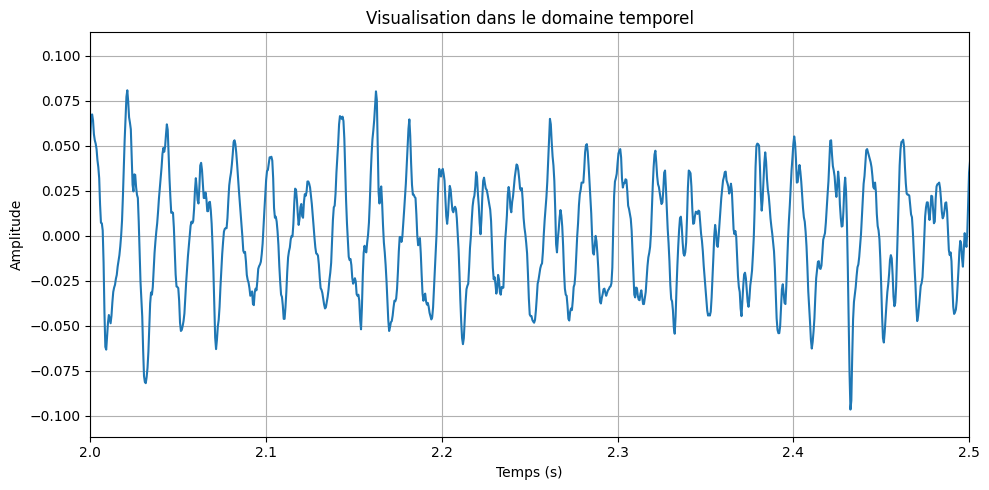

In [4]:
plt.figure(figsize = (10, 5))
plt.title("Visualisation dans le domaine temporel")
plt.plot(temps, sig_y)
plt.xlim(2, 2.5)
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()

### 3. Calcul du périodogramme modifé (méthode de Welch)

Text(0, 0.5, 'dB')

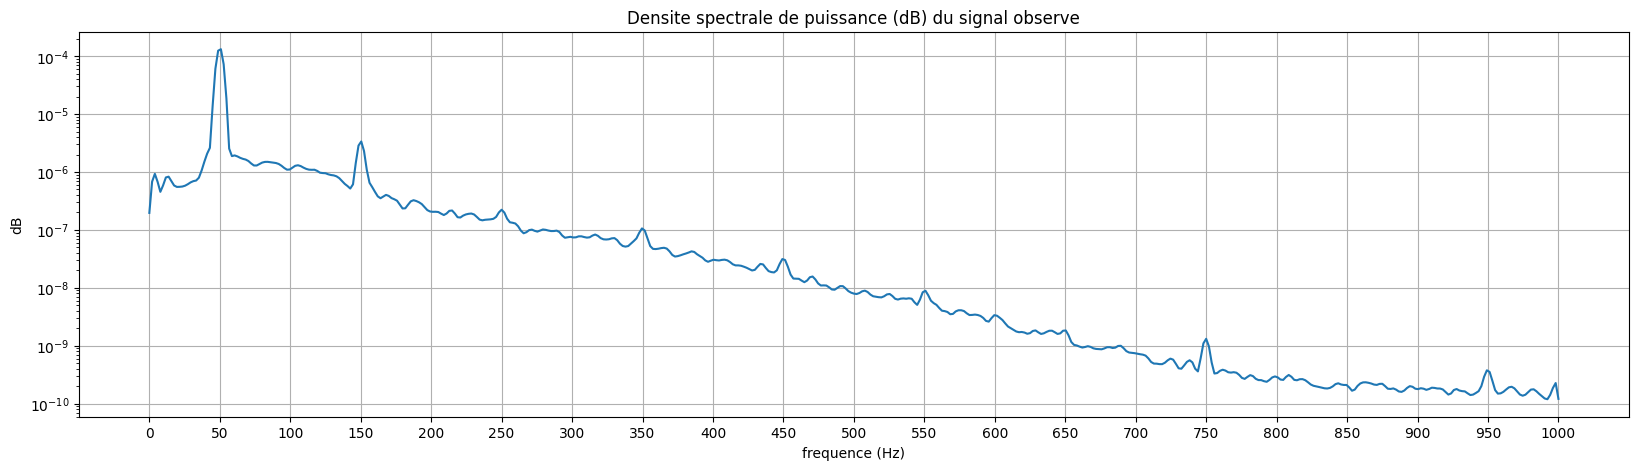

In [5]:
Nblocks = 512   # Taille des blocs pour lesquels on calcule la FFT
rec = int(3 * Nblocks /4) # Recouvrement de 75% entre blocs

hann_win = hann(Nblocks, True) # Fenetre de Hanning

# On estime le spectre sur Nblocks+1 points, i.e. avec une resolution 
# spectrale de Fe / (2 * Nblocks)
[freq, dspy] = welch(sig_y, Fe,
                     window=hann_win,
                     noverlap=rec, nfft=2*Nblocks)

plt.figure(figsize = (20, 5))
plt.grid()
# On représente la magnitude en dB dans le domaine spectral
plt.semilogy(freq, dspy)
plt.xticks(np.arange(0, 1001, 50))
plt.title("Densite spectrale de puissance (dB) du signal observe")
plt.xlabel("frequence (Hz)")
plt.ylabel("dB")



**Questions :** 
- Faites comme la figure précédente des vues dans des domaines de fréquences différents  (cf `plt.xlim(left,right)` pour afficher sur l'intervalle des abscisses [`left`,`right`]). 
- A quoi correspondent les raies visibles dans le spectre ?

## II. Estimation/Suppression de bruit périodique

En TNS, vous avez déjà vu comment réaliser des filtres passe-bas/haut/bande... Une solution serait de construire des filtres à encoches qui viennent couper toutes les fréquences bruitées. Cette solution serait un peu trop brutale dans notre cas, car on perdrait également beaucoup d'information utile dans la bande qui nous intéresse.

L'objectif dans la suite est de construire le filtre optimal qui *lisse au mieux (au sens de l'EQM) les raies parasites afin de rejeter le bruit tout en laissant passer l'information utile*.

### 1. Construction du filtre auto-ajusté optimal

On rappelle qu'on observe le signal $$y(t) = x(t) + \nu_p(t)$$ où $x(t)$ est le signal utile, large bande, centré, stationnaire au second ordre et $\nu_p(t)$ est un bruit périodique, décorrélé de $x(t)$.
On cherche le filtre optimal au sens de Wiener afin d’estimer la partie périodique du signal $s(t) \equiv  \nu_p(t)$
et donc accéder au signal utile large bande $x(t) = y(t)-\nu_p(t)$ (on parle de débruitage /restauration ou encore d'annulation / suppression de bruit).

Afin de synthétiser le filtre optimal, on rappelle qu'il est nécessaire de connaitre les fonctions de corrélation $\Gamma_{yy}(\cdot)$ et $\Gamma_{sy}(\cdot)$. L'autocorrélation $\Gamma_{yy}(\cdot)$ peut être estimée directement à partir des données $y(t)$.
Mais pour estimer l'intercorrélation $\Gamma_{sy}(\cdot)$ entre les observations et le bruit, il 
serait nécessaire disposer d'une référence ''bruit seul''...

Comme c'est expliqué dans l'énoncé du [BE sur Wiener](https://chamilo.grenoble-inp.fr/courses/ENSE3A24EMAABJ0/document/BE_1/BE_wiener.pdf?cidReq=ENSE3A24EMAABJ0&id_session=0&gidReq=0&gradebook=0&origin=) 
il est possible pour ce problème  de construire une référence bruit seul à parti du seul signal observé $y(t)$ ! 

A la place d'une référence ''bruit seul'', on peut considérer le signal observé retardé $y_r(t)=y(t-\tau')$
où le retard $\tau'$ doit satisfaire les **deux contraintes** suivantes :
- $\tau'= k_0 T$ est un **multiple de période du bruit $T$** 
- $\tau'\gg0$ est **suffisamment grand** par rapport à la longueur de la corrélation du signal large bande $x(t)$ 

Cela donne le filtre schématisé sur la figure ci-dessous. Le flèche diagonale qui traverse le filtre rappelle que les coefficients du filtre sont calculés à partir du signal retardé $y_r(t)$ : on parle de filtre **auto-ajusté**.

<!-- ![schéma du filtre auto-ajusté](./img/schema_filtre.svg)-->

![schéma du filtre auto-ajusté](https://gricad-gitlab.univ-grenoble-alpes.fr/ds-courses/materials-optimal-filtering/-/raw/master/figs/BE1/schema_filtre.svg?inline=false)
#### a) Estimer  l'*ordre de grandeur* de la longueur $N$ du filtre <b>RIF</b> (variable `Nrif`).

On va chercher à estimer cet ordre de grandeur à parti du **spectre du signal observé** représenté dans le graphique de la celle précédente.

**Rappel** (cf méthode des fenêtres en TNS) : 
- La largeur de la bande de transition (raideur) en *fréquence normalisée* d'un filtre RIF est *de l'ordre de* $1/N$
- Quelle largeur de bande de transition ? Il faudrait ici qu'elle soit plus petite que la demi-largeur des pics à filtrer

Cet ordre de grandeur sera utile pour obtenir une _première_ implémentation du filtre.  Il faudra _ensuite l'optimiser_ afin de vérifier si le filtre est suffisamment raide (i.e. $N$ suffisamment grand) ou à l'inverse si on ne peut pas le simplifier (i.e. $N$ plus petit) en conservant des performances de filtrage correctes.

In [6]:
Nrif = 1 # FIXME: choisir une valeur appropriée pour l'ordre du filtre

#### b) Estimer et Visualiser la fonction de corrélation du signal observé

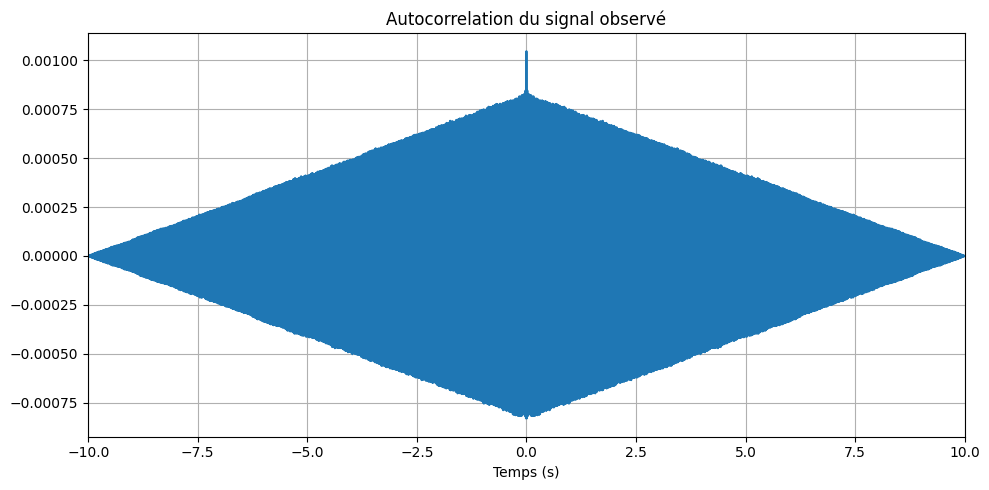

In [7]:
# Calcul de l'autocorrélation
[cy, lags] = xcorr(sig_y, sig_y, scale='biased')

# Affichage pour tous les retards possibles
plt.figure(figsize = (10, 5))
plt.grid()
plt.xlim(-10, 10) # to be change to focus on smaller aera for the lags
plt.plot(lags / Fe, cy)
plt.title("Autocorrelation du signal observé")
plt.xlabel("Temps (s)")
plt.tight_layout()

**Questions** (*Indice : re-voir le cours sur le filtre de Wiener discret slide 15*) : 
- pourquoi la corrélation ainsi estimée à une enveloppe triangulaire ?
- que se passe t'il si on change d'estimateur en prenant la version non-biaisée (option `'unbiased'`)



Dans notre application, on se limitera à des retards négligeables devant la longueur des signaux. Quel estimateur vous semble alors préférable (pensez ensuite à toujours utiliser le même estimateur par la suite) ?


In [8]:
scale = 'biased' # FIXME: Choisir la normalisation qui vous semble la plus appropriée

In [9]:
# Affichage de l'autocorrélation pour de petits retards

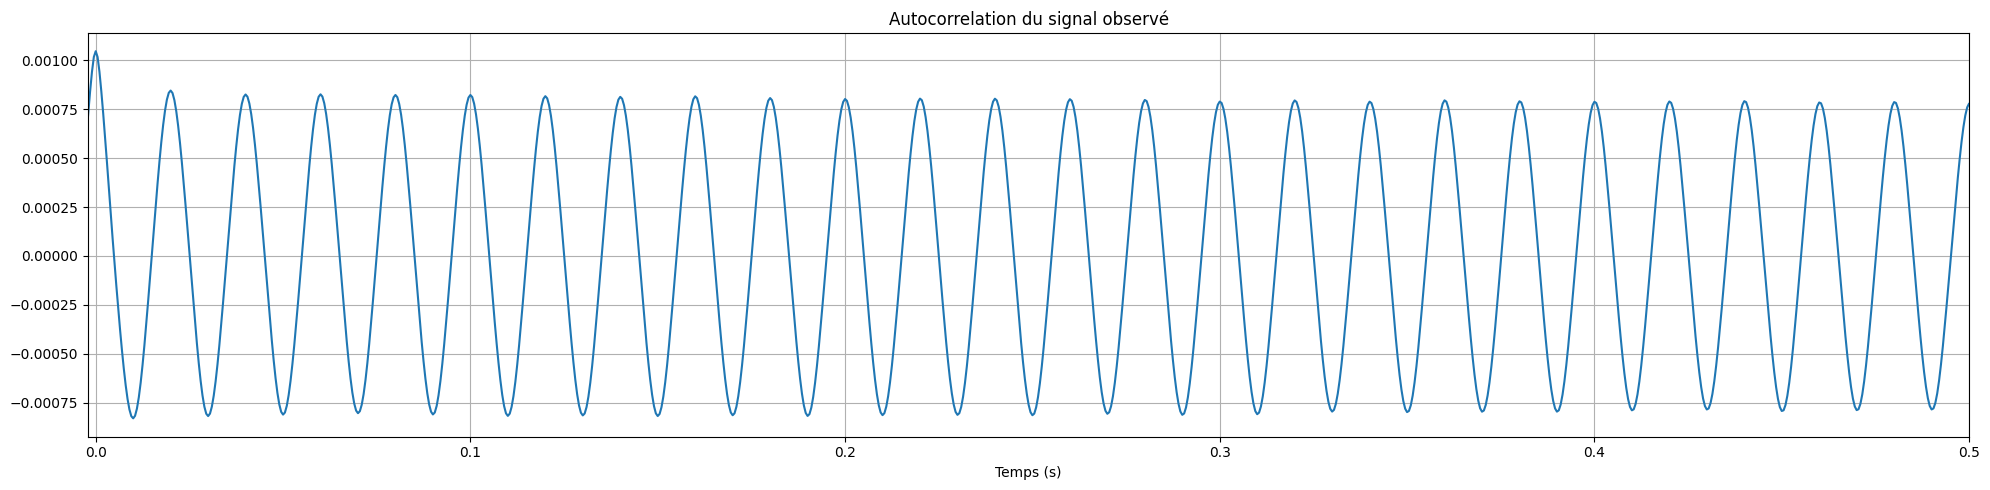

In [10]:
plt.figure(figsize = (20, 5))
plt.grid()
plt.xlim(-0.002, .5) 
plt.plot(lags / Fe, cy)
plt.title("Autocorrelation du signal observé")
plt.xlabel("Temps (s)")
plt.tight_layout()

#### c) Construire la référence bruit seul à partir du signal retardé  $y_r$ 

**Questions :** En analysant le graphique précédent
1. déterminer à partir de quel retard l'autocorrélation devient un signal (quasi)-périodique ?
2. que peut-on en déduire pour la fonction d'autocorrélation du signal EMG utile ?
3. quelle valeur  du retard ``M`` **en nombre d'échantillons** choisir pour la suite (on rappelle que, pour cette partie au moins, M doit être un **multiple de la période du bruit**) ?

Valeur appropriée du retard ``M`` en nombre d'échantillons à appliquer.

In [11]:
M = 0   # FIXME: choisir une valeur appropriée 

Construction des signaux de référence: $y$ décalé temporellement et $y_r$ (signal retardé de `M` échantillons).

In [12]:
# Changement d'origine des temps
y = sig_y[M::]
L = y.shape[0]
temps = temps[M::] # Domaine temporel associé à y
y_retard = sig_y[0:L]
# les deux ndarray utiles sont maintenant y et y_retard

#### d) Construire le filtre de Wiener (filtre auto-ajusté optimal).

On rappelle la réponse $\boldsymbol{w}$ du filtre de Wiener RIF (N+1) est la solution de l’équation de Wiener-Hopf suivante :

<!--
\begin{array}{cccc}
\underbrace{
\begin{pmatrix}
 \Gamma_{sy}[0] \\
 \Gamma_{sy}[1] \\
  \vdots \\
  \vdots \\
 \Gamma_{sy}[N]
\end{pmatrix}
}
&= &
\underbrace{\begin{pmatrix}
 \Gamma_{y}[0] &\Gamma_{y}[1]&  \ldots & \ldots &  \Gamma_{y}[N] \\
 \Gamma_{y}[1] &\Gamma_{y}[0]&  \ldots & \ldots &  \Gamma_{y}[N-1] \\
 \vdots & \vdots & \ddots  & & \vdots \\
  \vdots & \vdots &  & \ddots & \vdots \\
 \Gamma_{y}[N] & \Gamma_{y}[N-1]  &    \ldots & \ldots &  \Gamma_{y}[0]
\end{pmatrix}}
&
\underbrace{
\begin{pmatrix}
 w_0 \\
 w_1\\
  \vdots \\
   \vdots \\
 w_N
\end{pmatrix}},\\
\boldsymbol{\Gamma_{sy}} & = & \boldsymbol{\Gamma_{y}} & \boldsymbol{w}
\end{array}
-->

![Equtions de Wiener-Hopf](https://gricad-gitlab.univ-grenoble-alpes.fr/ds-courses/materials-optimal-filtering/-/raw/master/figs/BE1/equation-WH.svg?inline=false)


Afin de former ce système puis de le résoudre, il est d'abord nécessaire d'estimer les fonctions de corrélation 
$\Gamma_{y}[\cdot]$ et $\Gamma_{sy}[\cdot]$ pour tous les retards $r=0,\ldots,$`Nrif`.

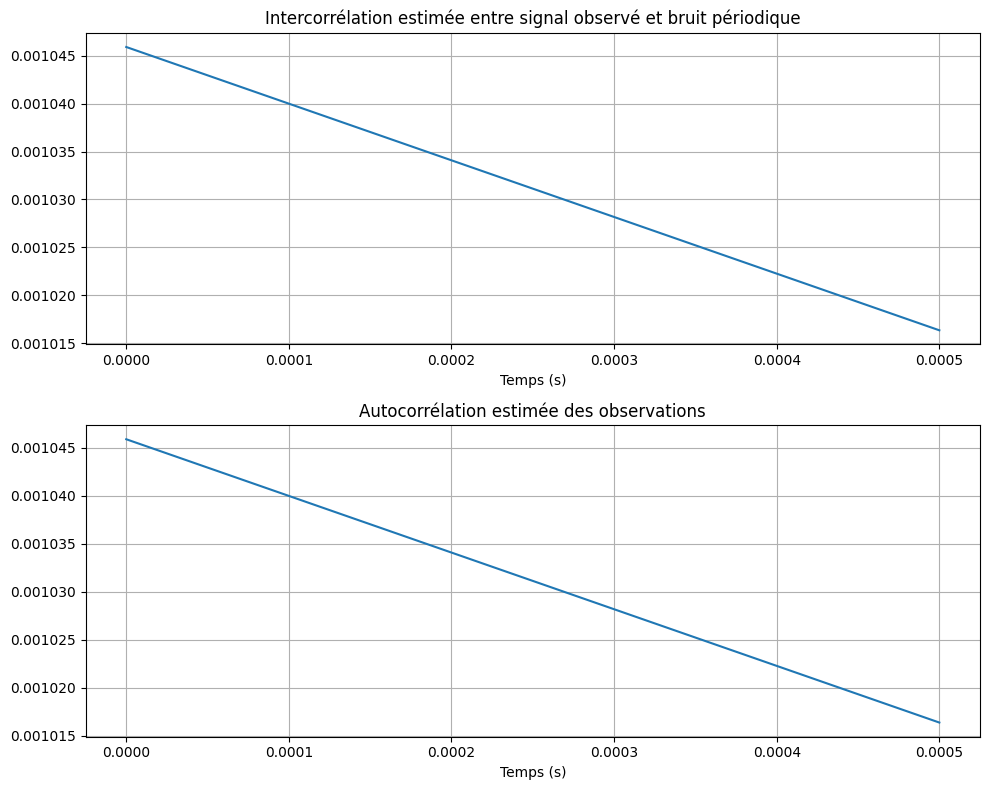

In [13]:
# Estimation de l'intercorrélation Gamma_sy
[inter_sy, lags] = xcorr(y, y_retard, maxlag = Nrif, scale=scale)
# On regarde dans [0, Nrif] et on ne garde que les retards positifs
inter_sy = inter_sy[Nrif:]
lags = lags[Nrif:] / Fe  # En secondes

# Estimation de l'autocorrélation Gamma_y
auto_y, _ = xcorr(y, y, maxlag = Nrif, scale=scale)
auto_y = auto_y[Nrif:]

# Affichage
plt.figure(figsize = (10, 8))
plt.subplot(2, 1, 1)
plt.grid()
plt.plot(lags, inter_sy)
plt.title("Intercorrélation estimée entre signal observé et bruit périodique")
plt.xlabel("Temps (s)")
plt.tight_layout()
plt.subplot(2, 1, 2)
plt.grid()
plt.plot(lags, auto_y)
plt.title("Autocorrélation estimée des observations")
plt.xlabel("Temps (s)")
plt.tight_layout()

**Question :** Quelle différence constatez vous entre les fonctions d'inter et d'auto-corrélations et à quoi est-elle due ?

On peut maintenant calculer des coefficients du filtre optimal : résolution de l'équation de Wiener-Hopf

$$\boldsymbol{w}=\boldsymbol{\Gamma_{y}}^{-1}\boldsymbol{\Gamma_{sy}}$$

In [14]:
# Mise en forme des vecteurs et de la matrice de corrélation
# cf aide `help()` des méthodes 
# `toeplitz()` pour créer une matrice toeplitz symétrique à partir de la première ligne
# `solve()` pour résoudre un système linéaire

# Gamma_y est une matrice taille (Nrif+1) x (Nrif+1)
Gamma_y = np.zeros((Nrif+1, Nrif+1)) # FIXME: former la matrice Gamma_y

# Gamma_sy est un vecteur taille (Nrif+1)
Gamma_sy = np.zeros((Nrif+1,))  # FIXME: former le vecteur Gamma_sy 

# Calcul de la réponse du filtre de longueur (Nrif+1) dans le vecteur nommé 'coeff'
coeff = np.random.normal(size=(Nrif+1,))  # FIXME: calculer la solution w de W-H  

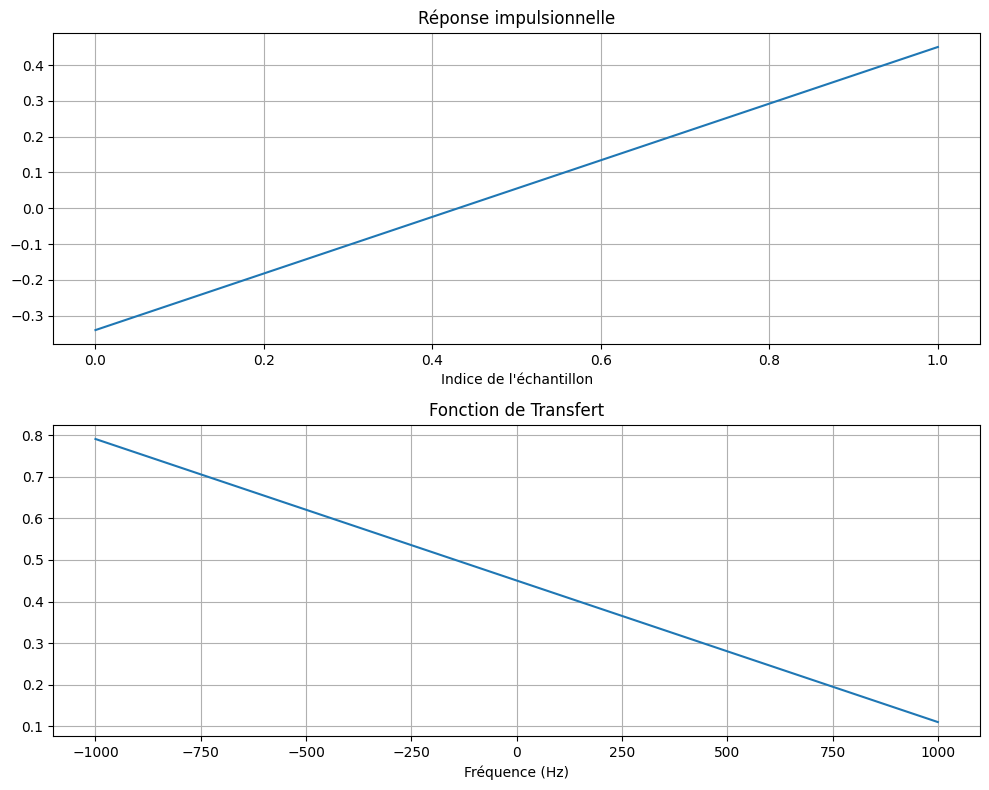

In [15]:
# Affichage
plt.figure(figsize = (10, 8))
plt.subplot(2, 1, 1)
plt.grid()
plt.plot(np.arange(Nrif + 1), coeff)
plt.title("Réponse impulsionnelle")
plt.xlabel("Indice de l'échantillon")
plt.tight_layout()
plt.subplot(2, 1, 2)
plt.grid()
plt.plot((np.arange(Nrif + 1) / Nrif - 0.5) *Fe,
         np.abs(np.fft.fftshift(
             np.fft.fft(coeff))) )
plt.title("Fonction de Transfert")
plt.xlabel("Fréquence (Hz)")
plt.tight_layout()

**Remarques sur les deux graphiques précédents**

Il est difficile d'interpréter visuellement la forme de la réponse impulsionnelle. Par contre, la fonction de transfert devrait faire apparaître des raies autour des fréquences de bruit (on rappelle qu'on estime ici le bruit périodique afin de pouvoir le soustraire par la suite)


### 2. Estimer / Supprimer la composante périodique

#### a) Bruit périodique

In [16]:
# Filtre RIF : Le dénominateur de la fonction de transfert rationnelle dans le
# domaine de la TZ est [1, 0, ..., 0]
a = np.zeros((coeff.shape[0])) 
a[0] = 1
# Estimation optimale du bruit
vpest_rif = lfilter(coeff, a, y) 
# DSP du bruit estimé
_, dspvp = welch(vpest_rif, Fe,
                 window=hann_win,
                 noverlap=rec, nfft=2*Nblocks)

#### b) Signal utile

**Question :** Comment estimer le signal utile $x$ (signal large bande) à partir du signal observé $y$ et de l'estimateur du bruit $\hat{\nu}_p$ ?

In [17]:
# Estimation optimale du signal large bande
xest_rif = y # FIXME: mettre la bonne valeur

# DSP du bruit estimé
_, dspx = welch(xest_rif[Nrif::], Fe,
                window=hann_win,
                noverlap=rec, nfft=2*Nblocks)

#### c) Périodogramme du signal utile : Visualisations et Comparaisons

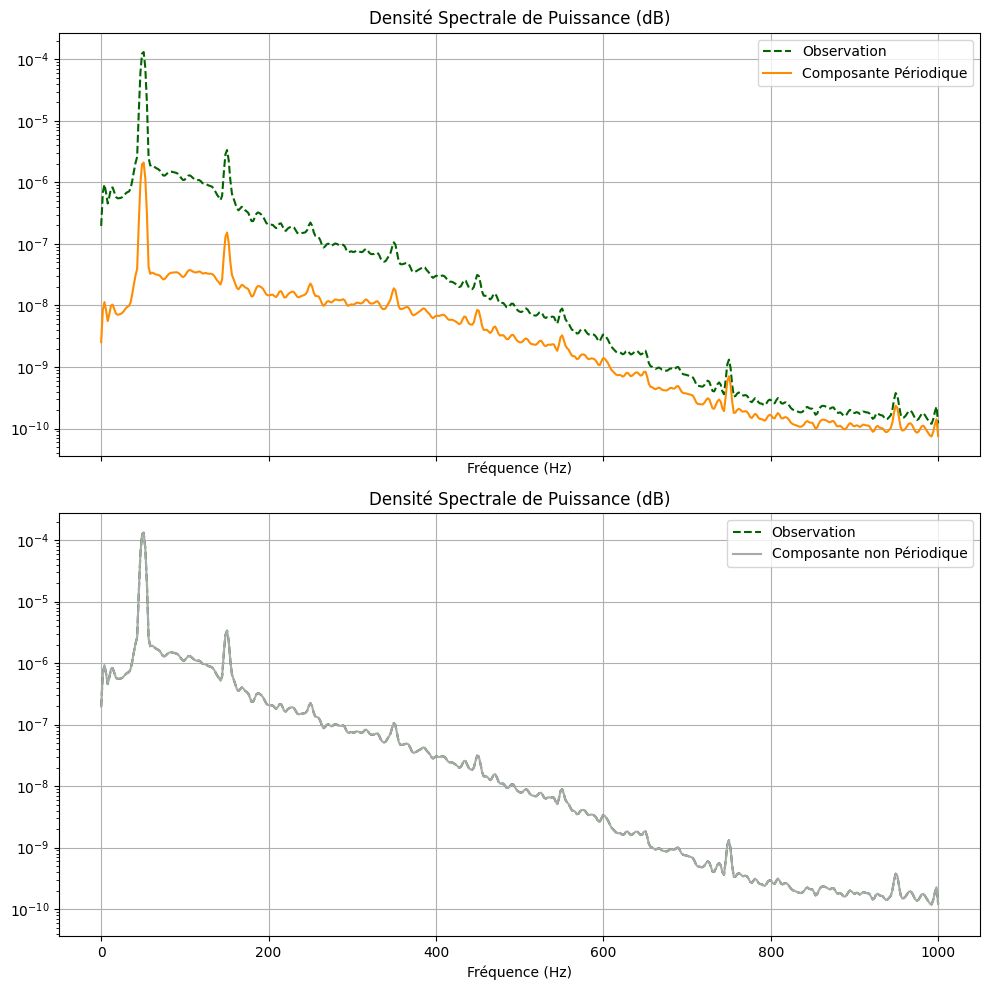

In [18]:
# Affichage
plt.subplots(2, 1, figsize = (10, 10), sharex=True, sharey=True)
plt.subplot(2, 1, 1)
plt.grid()
plt.semilogy(freq, dspy, '--', color='darkgreen', label = 'Observation')
plt.semilogy(freq, dspvp, '-', color='darkorange', label = 'Composante Périodique')
plt.title("Densité Spectrale de Puissance (dB)")
plt.xlabel("Fréquence (Hz)")
plt.legend()
plt.tight_layout()
plt.subplot(2, 1, 2)
plt.grid()
plt.semilogy(freq, dspy, '--', color='darkgreen',  label = 'Observation')
plt.semilogy(freq, dspx, '-', color='darkgrey',  label = 'Composante non Périodique')
plt.title("Densité Spectrale de Puissance (dB)")
plt.xlabel("Fréquence (Hz)")
plt.legend()
plt.tight_layout()

#### d) Visualisation des résultats dans le domaine temporel.

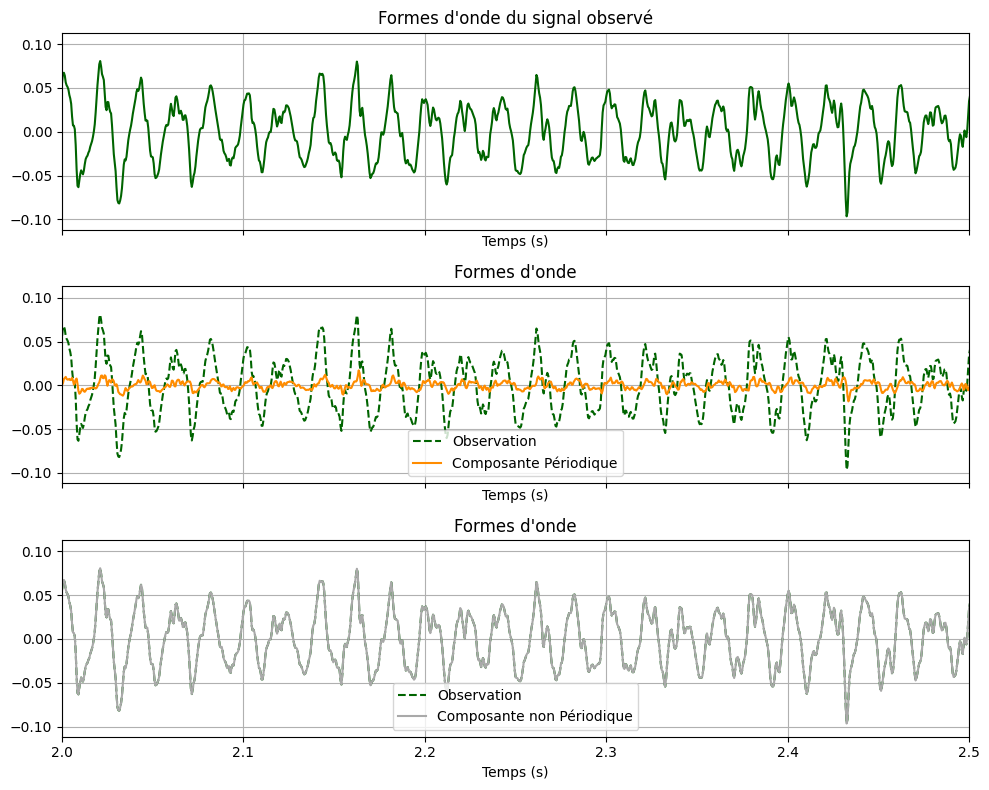

In [19]:
# Affichage
plt.subplots(3, 1, figsize = (10, 8), sharex=True, sharey=True)
plt.subplot(3, 1, 1)
plt.grid()
plt.plot(temps, y, '-', color='darkgreen')
plt.title("Formes d'onde du signal observé")
plt.xlabel("Temps (s)")
plt.xlim(2, 2.5)
plt.tight_layout()
plt.subplot(3, 1, 2)
plt.grid()
plt.plot(temps, y, '--', color='darkgreen', label = 'Observation')
plt.plot(temps, vpest_rif, '-', color='darkorange', label = 'Composante Périodique')
plt.title("Formes d'onde")
plt.xlabel("Temps (s)")
plt.xlim(2, 2.5)
plt.legend()
plt.tight_layout()
plt.subplot(3, 1, 3)
plt.grid()
plt.plot(temps, y, '--', color='darkgreen', label = 'Observation')
plt.plot(temps, xest_rif, '-', color='darkgrey', label = 'Composante non Périodique')
plt.title("Formes d'onde")
plt.xlabel("Temps (s)")
plt.xlim(2, 2.5)
plt.legend()
plt.tight_layout()

## III. Prédiction / Suppression du bruit périodique à partir du signal retardé



### Filtre prédicteur

Le filtre de Wiener permettant d’estimer (puis de supprimer) un bruit périodique est  vu maintenant
comme un problème de prédiction du bruit périodique à partir du signal retardé. Ceci revient à considérer 
le modèle suivant :
- $y'(t) \equiv y_r(t) = x(t -\tau') +  \nu_p(t -\tau'), \quad$ l'observation à l'instant $t$
- $s(t) \equiv \nu_p(t), \quad$ le signal à estimer

et donc à synthétiser le filtre schématisé sur la figure ci-dessous

<!-- ![Schéma du filtre prédicteur](./img/schema_predicteur.svg)-->
![Schéma du filtre prédicteur](https://gricad-gitlab.univ-grenoble-alpes.fr/ds-courses/materials-optimal-filtering/-/raw/master/figs/BE1/schema_predicteur.svg?inline=false)

**Questions :**
1. Montrer que $\Gamma_{y'}(\tau)= \Gamma_{y}(\tau)$ et que **pour tout** $\tau' > 0$
suffisamment grand, $\Gamma_{sy'}(\tau)= \Gamma_{yy'}(\tau)$
2. Quel est alors l’avantage de ce modèle par rapport au filtre précédent (partie II) afin de choisir $\tau'$ et donc
le retard équivalent en nombre d’échantillons `M` ?


#### a) Valeur appropriée du retard ``M`` en nombre d'échantillons à appliquer (on pourra prendre une valeur qui n'est plus un multiple de la période pour tester la méthode)

In [20]:
# Retard en nombre d'échantillons
M = 0 # FIXME: choisir une valeur appropriée

In [21]:
# Changement d'origine des temps
y = sig_y[M::]
L = len(y)
temps = np.arange(M, N) / Fe
y_retard = sig_y[0:L]

#### b) Construction du filtre - estimation des fonctions de corrélation

In [22]:
# Estimation de l'intercorrélation -
[inter_sy, lags] = xcorr(y, y_retard, maxlag = Nrif, scale = scale)
inter_sy = inter_sy[Nrif:]

**Question :**  est-il nécessaire de recalculer l'autocorrélation $\Gamma_{y'}(\tau)$ sachant qu'on a déjà calculé $\Gamma_{y}(\tau)$ dans la partie II précédente ?

#### c) Construction du filtre - résolution de W-H et filtrage

On pourra tester différentes valeur de `M` et comparer les résultats avec ceux de la partie II précédente

In [23]:
#FIXME: à terminer en adaptant directement le code de la partie précédante